### Задание:
Предположим в ряде городов в определенный период проведен тест:  
В тестовых городах на веб-сайте пиццы располагаются по популярности  
Во всех остальных по увеличению цены на пиццу  
Вопросы:  
На какие метрики мог повлиять тест?  
Сделайте визуальный анализ датасета. Как ведут себя метрики в динамике? Какие распределения в данных?  
Как можно оценить эффект от теста? Если знаете несколько способов, реализуйте один, а другие опишите письменно.  
Порассуждайте письменно, какие метрики можно было бы еще оценить, если бы вам были доступны все данные компании.  

Тестовый период: 7 апреля - 19 мая
Тестовые города: Пенза, Уфа, Курск, Нижний Тагил, Новокуйбышевск, Орск

### Описание датасета:  
**Date:** дата  
**CityName:** город  
**OrderSource:** источник заказа - mp: мобильное приложение, web: веб-сайт, other - другое  
**Category:** категория товара  
**rto:** выручка после скидок  
**rto_do:** выручка до скидок  
**cost:** затраты на себестоимость товаров  
**tickets:** кол-во заказов  
**qty:** кол-во продуктов  
**clients_qty:** уникальное кол-во клиентов  
**avg_time:** среднее время сессии (только по тем, кто оформил заказ)  
**avg_price:** средняя цена  

! В исходном датасете данные уже сгруппированы по Date, CityName, OrderSource, Category

### Решение:

**На какие метрики мог повлиять тест?**  

**можно было бы оценить**, если бы были доступны все данные компании:  
* конверсия (в клики/продажи)   

Также интересно было бы сравнить, насколько сильно визуально отличаются расположение пицц по популярности и расположение по убыванию цены.

**можно оценить сейчас:**  
* выручка  
* количество продуктов в заказе  
* средняя цена  

##### Допустим:  
метрика: **выручка**  
H0: **выручка в группах одинаковая** (изменения не вызвали рост выручки)    
H1: **выручка в тестовой группе больше, чем в контрольной**  
Критерий: **Манна-Уитни**  
уровень значимости: **0.05**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [5]:
df = pd.read_csv(
    'C:/Users/olegs/Downloads/оценка_категорий.csv',
    dtype={'tickets':'int32', 'qty':'int32', 'clients_qty':'int32'},
    parse_dates=['Date'],
    date_parser = lambda x: x.rpartition('T')[0]
).drop_duplicates()
print(df.shape)
df.head(3)

(554830, 12)


,Date,CityName,OrderSource,Category,rto,rto_do,cost,tickets,qty,clients_qty,avg_time,avg_price
0,2022-01-01,Абакан,mp,пицца,83118.110,83162.76,19535.9630,61,152,123,24.278042,546.82965
1,2022-01-01,Абакан,mp,закуски,13115.895,12950.67,4141.1035,15,64,45,40.270145,204.93585
2,2022-01-01,Абакан,mp,напитки,1862.760,2533.80,854.5993,9,20,22,37.050053,93.13800


In [6]:
alpha = 0.05

test_cities = ['Пенза', 'Уфа', 'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск']

start_date='2022-04-07'
end_date='2022-05-19'
pilot_duration = pd.date_range(start=start_date, end=end_date)

##### проставим флаги на контрольную и тестовую группы:

In [7]:
test_idx = df[
    (df['CityName'].isin(test_cities)) & 
    (df['OrderSource'] == 'web') & 
    (df['Date'].isin(pilot_duration)) & 
    (df['Category'] == 'пицца')
].index

control_idx = df[
    (df['CityName'].isin(test_cities)==False) & 
    (df['OrderSource'] == 'web') & 
    (df['Date'].isin(pilot_duration)) & 
    (df['Category'] == 'пицца')
].index

df['flag'] = None
df.loc[test_idx, 'flag'] = 'test'
df.loc[control_idx, 'flag'] = 'control'

In [8]:
df['flag'].value_counts()

control    11132
test         258
Name: flag, dtype: int64

##### распределение выручки (гамма-распределение):

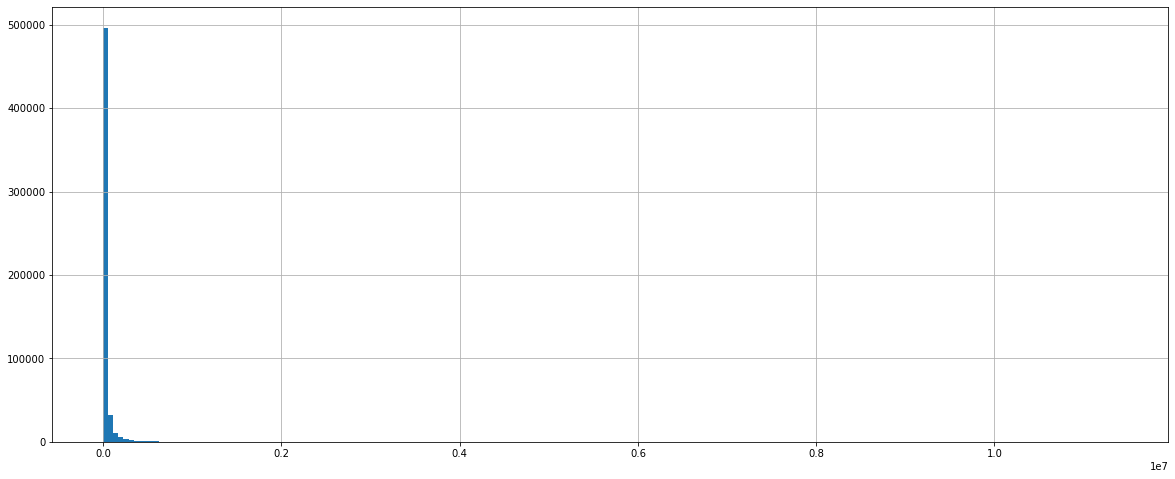

In [9]:
df['rto'].hist(bins=200, figsize=(20,8));

##### проверим, совпадает ли характер распределения в группах:

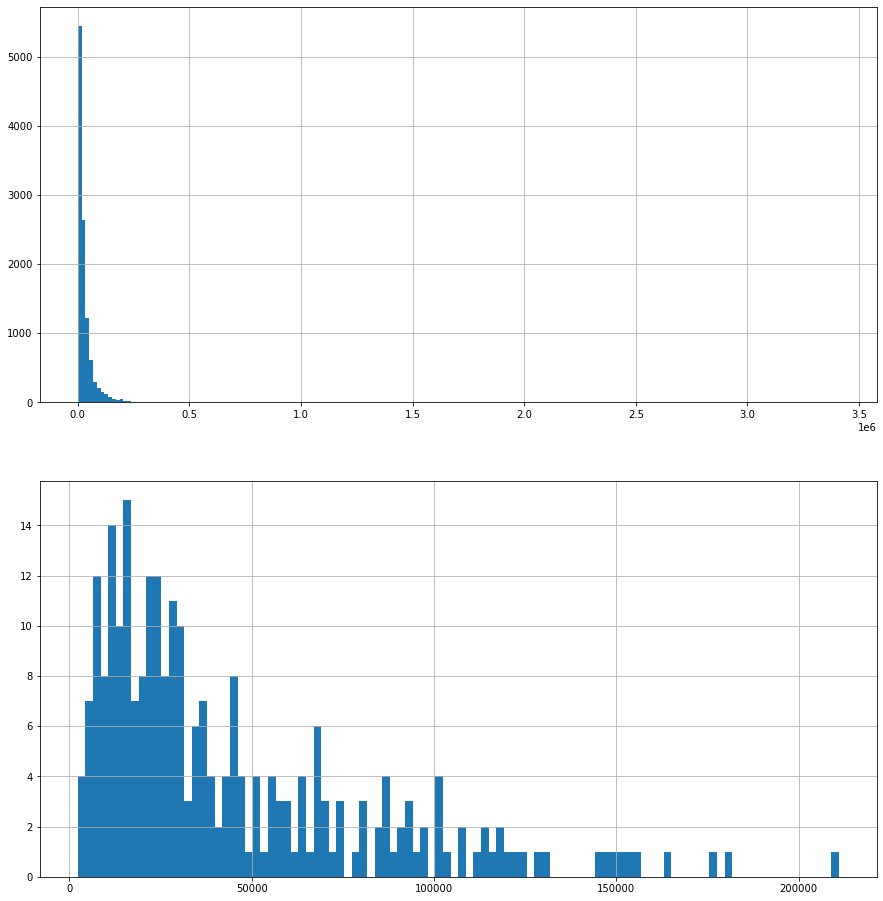

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(15, 16))
df[df['flag'] == 'control']['rto'].hist(bins=200, ax=ax[0]);
df[df['flag'] == 'test']['rto'].hist(bins=100, ax=ax[1]);

Совпадает (с поправкой на масштаб).

##### Описательные статистики по тестовой группе:

In [11]:
df[df['flag'] == 'test']['rto'].describe()

count       258.000000
mean      44493.428136
std       39102.581100
min        2278.140000
25%       16552.728750
50%       29590.155000
75%       63289.062000
max      210923.730000
Name: rto, dtype: float64

In [12]:
df[df['flag'] == 'control']['rto'].describe()

count    1.113200e+04
mean     4.267676e+04
std      1.517853e+05
min      0.000000e+00
25%      8.095801e+03
50%      1.761753e+04
75%      3.683084e+04
max      3.408841e+06
Name: rto, dtype: float64

Матожидание сопоставимо, при этом дисперсия в предположительно контрольной группе почти в 4 раза выше, также она содержит почти в 50 раз больше наблюдений, чем в тестовой.  
Учитывая различия, а также тот факт, что города тестовой группы (кроме Уфы) небольшие, а в предположительно контрольной есть Москва и Санкт-Петербург, можно сделать вывод, что группа городов для контроля "внутри" остальных городов, а не все остальные города.

##### Выделю города, похожие на тестовые для восстановления контрольной группы

Предположим, города похожи по средним характеристикам

In [13]:
data_per_city = df[
    (df['OrderSource'] == 'web') & 
    (df['Category'] == 'пицца') &
    (df['Date'] < start_date)
].groupby('CityName').mean().reset_index()

data_per_city[data_per_city['CityName'].isin(test_cities)]

,CityName,rto,rto_do,cost,tickets,qty,clients_qty,avg_time,avg_price
114,Курск,33644.831490,35375.402187,7903.613923,44.885417,60.072917,49.635417,27.015759,557.574263
152,Нижний Тагил,37949.653854,40713.884063,9483.008170,56.197917,77.458333,55.750000,26.178769,488.032384
155,Новокуйбышевск,18008.065375,19804.857813,4288.279036,27.020833,36.447917,25.718750,27.066274,494.524271
173,Орск,13754.239172,13969.789062,3365.714919,19.156250,25.395833,19.500000,27.302090,543.104768
176,Пенза,70625.253812,77317.531042,17108.821568,89.145833,136.906250,97.239583,26.269453,515.173816
242,Уфа,104484.138135,111813.059688,25200.272313,140.260417,208.677083,141.802083,27.412228,502.036674


Средние признаков разнятся в пределах даже тестовой группы, хотя она должна быть однородной.  
Стоит посмотреть на другие характеристики.  
Если эксперимент касался интерфейса заказа пиццы на сайте, стоит посмотреть на долю таких заказов в общем объеме по городам.

In [14]:
#создадим колонку с количеством заказов на сайте за день по каждому городу

df['tickets_web_per_day'] = df[['CityName', 'Date', 'OrderSource', 'tickets']].\
groupby(['CityName', 'Date', 'OrderSource']).transform('sum')


#и общим количеством заказов за день по каждому городу

df['tickets_total_per_day'] = df[['CityName', 'Date', 'tickets']].\
groupby(['CityName', 'Date']).transform('sum')

In [35]:
# для удобства сохраним индексы строк, в которых содержатся данные о заказах пиццы через сайт

web_pizza_idx = df[(df['OrderSource'] == 'web') & (df['Category'] == 'пицца')].index

In [19]:
#посчитаем долю заказов пиццы через сайт от общего числа заказов через сайт
#и общего числа заказов по городам и месяцам

web_pizza_ratio = df.loc[web_pizza_idx, ['CityName', 'Date', 'tickets', 'tickets_web_per_day', 'tickets_total_per_day']].\
groupby(['CityName', df['Date'].dt.month])['tickets', 'tickets_web_per_day', 'tickets_total_per_day'].sum().reset_index()

web_pizza_ratio.rename(
    columns={
        'Date':'Month', 
        'tickets':'Web_pizza', 
        'tickets_web_per_day': 'Web',
        'tickets_total_per_day': 'Total'
    }, inplace=True)

web_pizza_ratio['Web_ratio'] = web_pizza_ratio['Web_pizza'] / web_pizza_ratio['Web']
web_pizza_ratio['Total_ratio'] = web_pizza_ratio['Web_pizza'] / web_pizza_ratio['Total']
web_pizza_ratio.head()

C:\Users\olegs\AppData\Local\Temp/ipykernel_11236/2000720160.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  web_pizza_ratio = df.loc[web_pizza_idx, ['CityName', 'Date', 'tickets', 'tickets_web_per_day', 'tickets_total_per_day']].\


,CityName,Month,Web_pizza,Web,Total,Web_ratio,Total_ratio
0,Абакан,1,1076,1664,5618,0.646635,0.191527
1,Абакан,2,924,1420,5039,0.650704,0.183370
2,Абакан,3,829,1337,5100,0.620045,0.162549
3,Абакан,4,826,1326,5234,0.622926,0.157814
4,Абакан,5,809,1268,5503,0.638013,0.147011


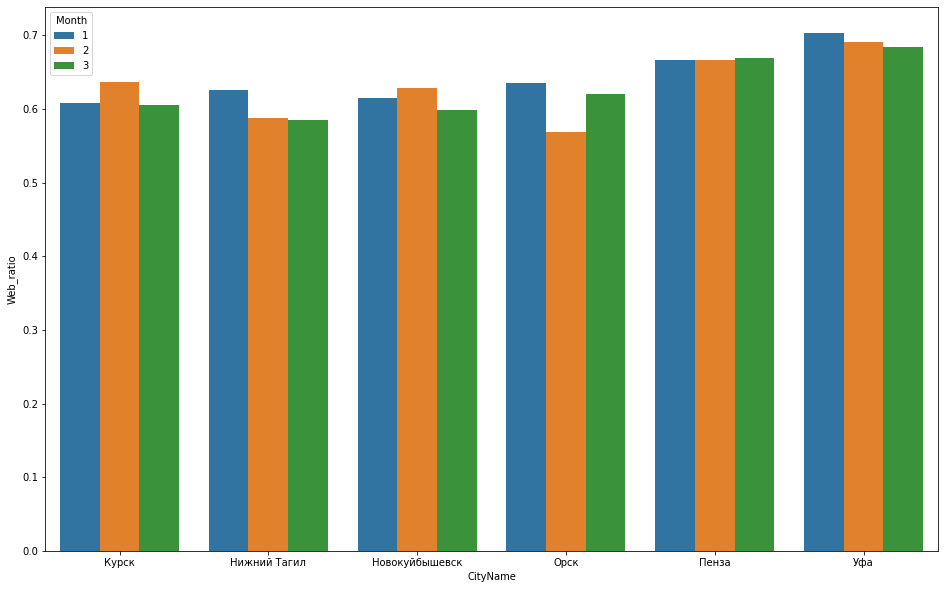

In [21]:
#отношение заказов пиццы через сайт ко всем заказам через сайт

fig = plt.figure(figsize=(16, 10))
data = web_pizza_ratio[(web_pizza_ratio['Month']<4) & (web_pizza_ratio['CityName'].isin(test_cities))]

sns.barplot(data = data, y = 'Web_ratio', x = 'CityName', hue='Month');

Визуально в пределах тестовой группы разница все еще есть.  
В цифрах почти 10%:

In [22]:
web_pizza_ratio[
    (web_pizza_ratio['Month']<4) & 
    (web_pizza_ratio['CityName'].isin(test_cities))
].groupby('CityName')['Web_ratio'].mean().sort_values()

CityName
Нижний Тагил      0.599676
Орск              0.608194
Новокуйбышевск    0.614167
Курск             0.616843
Пенза             0.667694
Уфа               0.692500
Name: Web_ratio, dtype: float64

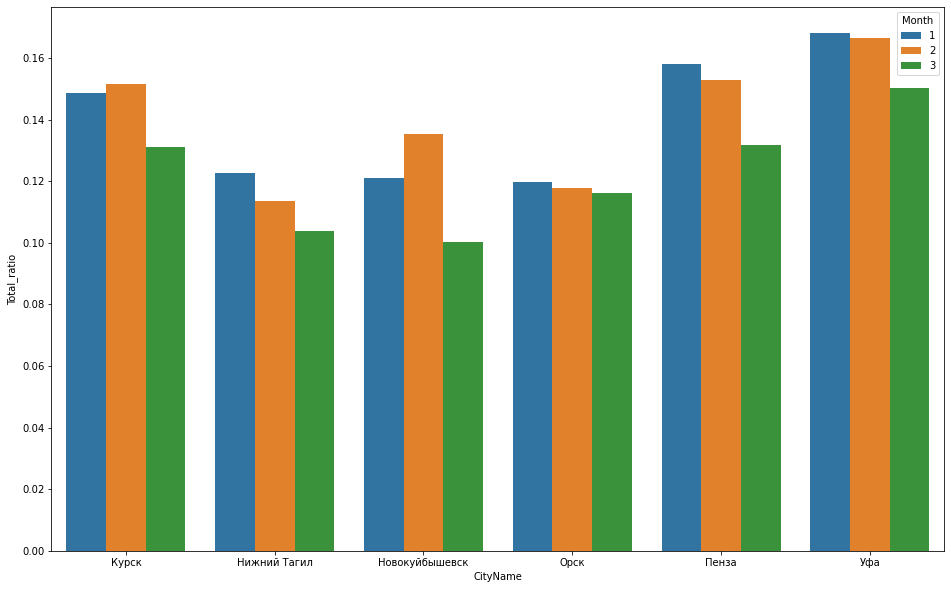

In [23]:
#отношение заказов пиццы через сайт ко всем заказам

fig = plt.figure(figsize=(16, 10))
data = web_pizza_ratio[(web_pizza_ratio['Month']<4) & (web_pizza_ratio['CityName'].isin(test_cities))]

sns.barplot(data = data, y = 'Total_ratio', x = 'CityName', hue='Month');

Разница также присутствует, в цифрах она достигает 5%:

In [24]:
web_pizza_ratio[
    (web_pizza_ratio['Month']<4) & 
    (web_pizza_ratio['CityName'].isin(test_cities))
].groupby('CityName')['Total_ratio'].mean().sort_values()

CityName
Нижний Тагил      0.113342
Орск              0.117912
Новокуйбышевск    0.118947
Курск             0.143728
Пенза             0.147462
Уфа               0.161536
Name: Total_ratio, dtype: float64

**Промежуточный итог:**    
Характеристику, по которой определялась однородность групп, достоверно установить по предоставленным данным не удалось.  
Найдем наиболее близкие по значениям города и примем их за контрольную группу с допущением, что в них в то же время не проводились эксперименты.

In [25]:
test_values = data_per_city[data_per_city['CityName'].isin(test_cities)].iloc[:,1:]
non_test_values = data_per_city[data_per_city['CityName'].isin(test_cities)==False].iloc[:,1:]

def most_similar(test_df, non_test_df):
    idxmin_list = []
    for idx in test_df.index:
        diff = non_test_df - test_df.loc[idx,:].values
        norm = diff.apply(np.linalg.norm, axis=1)
        idxmin_list.append(norm.idxmin())
    return idxmin_list
        
control_cities_ids = most_similar(test_values, non_test_values)

**Средние по тестовым городам:**

In [26]:
data_per_city[data_per_city['CityName'].isin(test_cities)]

,CityName,rto,rto_do,cost,tickets,qty,clients_qty,avg_time,avg_price
114,Курск,33644.831490,35375.402187,7903.613923,44.885417,60.072917,49.635417,27.015759,557.574263
152,Нижний Тагил,37949.653854,40713.884063,9483.008170,56.197917,77.458333,55.750000,26.178769,488.032384
155,Новокуйбышевск,18008.065375,19804.857813,4288.279036,27.020833,36.447917,25.718750,27.066274,494.524271
173,Орск,13754.239172,13969.789062,3365.714919,19.156250,25.395833,19.500000,27.302090,543.104768
176,Пенза,70625.253812,77317.531042,17108.821568,89.145833,136.906250,97.239583,26.269453,515.173816
242,Уфа,104484.138135,111813.059688,25200.272313,140.260417,208.677083,141.802083,27.412228,502.036674


**Средние по ближайшим городам визуально сопоставимы:**

In [27]:
data_per_city.loc[control_cities_ids,:]

,CityName,rto,rto_do,cost,tickets,qty,clients_qty,avg_time,avg_price
16,Барнаул,34110.759167,35134.783438,7357.223121,44.312500,58.093750,42.09375,27.623402,585.177914
137,Мурино,38559.539167,40853.886250,9090.489256,43.354167,73.093750,53.15625,26.493925,529.226814
203,Саров,18547.030211,19766.804688,4265.950195,23.958333,32.656250,25.93750,25.504061,571.995420
50,Горно-Алтайск,14071.616422,13879.935000,3193.983702,19.072917,25.843750,20.84375,26.864457,545.723271
140,Мытищи,72052.204583,74546.763438,16064.463967,85.625000,120.177083,80.87500,26.407264,600.885809
220,Сургут,108876.423729,114546.594479,20545.597854,94.114583,168.593750,116.37500,26.924503,646.630778


In [28]:
#скорректируем флаг

control_cities = data_per_city.loc[control_cities_ids, 'CityName'].tolist()

test_idx = df[
    (df['CityName'].isin(test_cities)) & 
    (df['OrderSource'] == 'web') & 
    (df['Date'].isin(pilot_duration)) & 
    (df['Category'] == 'пицца')
].index

control_idx = df[
    (df['CityName'].isin(control_cities)) & 
    (df['OrderSource'] == 'web') & 
    (df['Date'].isin(pilot_duration)) & 
    (df['Category'] == 'пицца')
].index

df.drop(columns=['flag', 'tickets_web_per_day', 'tickets_total_per_day'], inplace=True)
df['flag'] = None
df.loc[test_idx, 'flag'] = 'test'
df.loc[control_idx, 'flag'] = 'control'

In [29]:
#сравним объемы получившихся выборок

df['flag'].value_counts()

control    258
test       258
Name: flag, dtype: int64

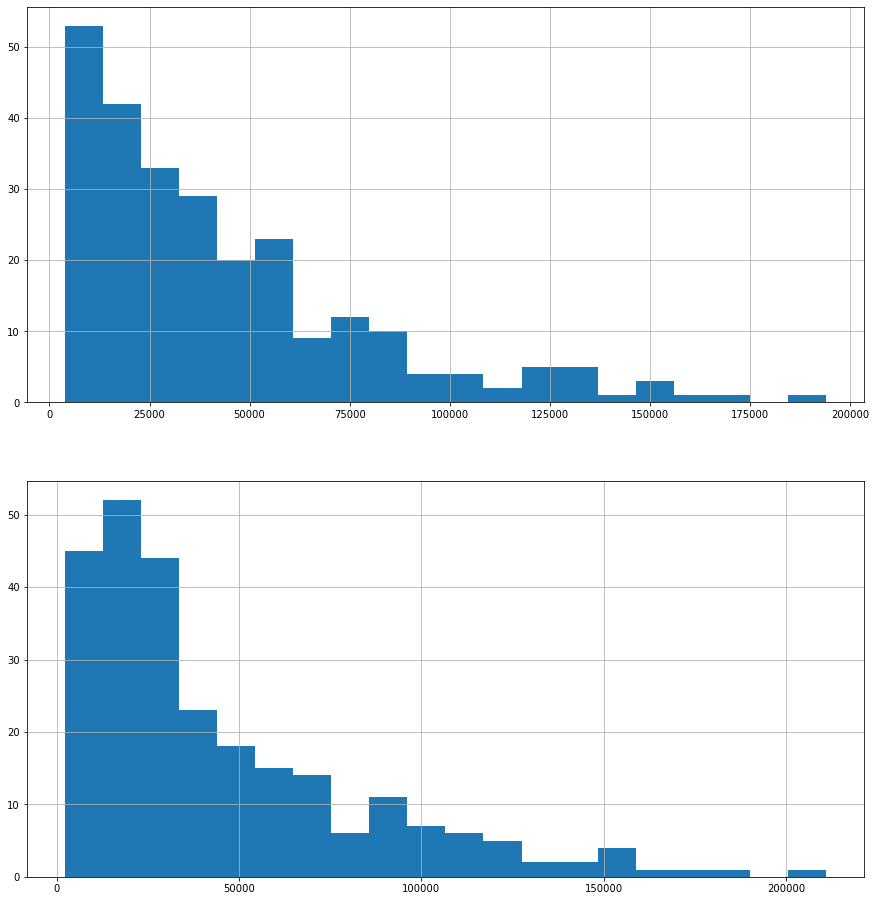

In [30]:
#сравним распределения

bins = 20

fig, ax = plt.subplots(2, 1, figsize=(15, 16))
df[df['flag'] == 'control']['rto'].hist(bins=bins, ax=ax[0]);
df[df['flag'] == 'test']['rto'].hist(bins=bins, ax=ax[1]);

In [31]:
df[df['flag'] == 'test']['rto'].describe()

count       258.000000
mean      44493.428136
std       39102.581100
min        2278.140000
25%       16552.728750
50%       29590.155000
75%       63289.062000
max      210923.730000
Name: rto, dtype: float64

In [32]:
df[df['flag'] == 'control']['rto'].describe()

count       258.000000
mean      43328.159341
std       36511.386108
min        3880.320000
25%       15130.732500
50%       32982.662000
75%       57651.652500
max      193953.300000
Name: rto, dtype: float64

##### Проведем U-тест Манна-Уитни:  
Воспользуемся методом mannwhitneyu() из модуля scipy библиотеки stats

In [33]:
array_c = df[df['flag'] == 'control']['rto'].values
array_t = df[df['flag'] == 'test']['rto'].values

stat, p_value = stats.mannwhitneyu(array_t, array_c, alternative='greater')
p_value < alpha

False

Так как p-value больше 0,05, то **у нас нет достаточных основания на заданном уровне доверия отвергать нулевую гипотезу.**  
При этом в качестве метрики могла быть выбрана другая, отличная от выручки, и результаты могли быть иными.

##### Посмотрим на метрики в динамике:

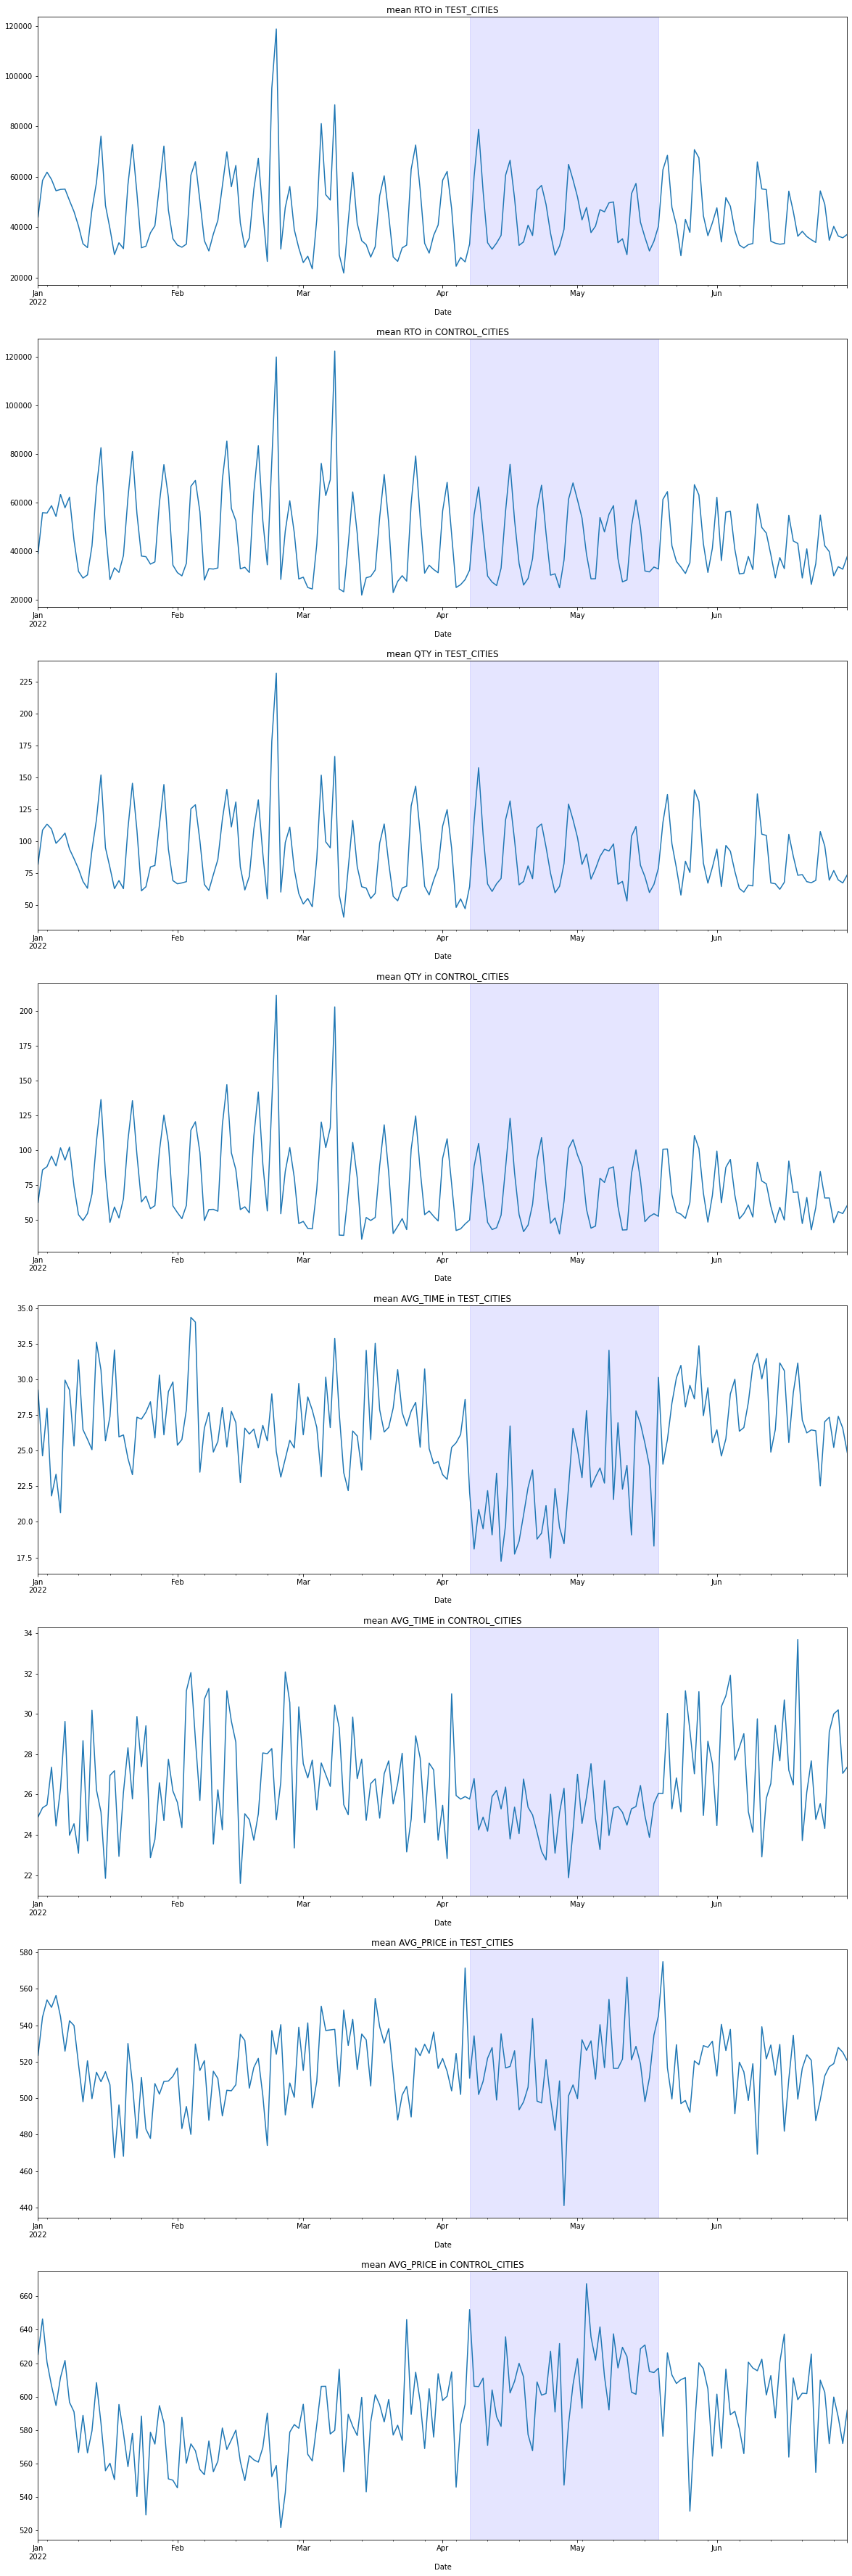

In [36]:
metric_list = ['rto', 'qty', 'avg_time', 'avg_price']

test_cities_idx = df[df['CityName'].isin(test_cities)].index

control_cities_idx = df[df['CityName'].isin(control_cities)].index

idx_dict = dict(
    zip(
        ['test_cities', 'control_cities'], 
        [test_cities_idx, control_cities_idx]
    )
)

def plot_in_dynamic(df, metrics_arr, index_dict):
    fig, ax = plt.subplots(2*len(metrics_arr), 1, figsize=(20, 16*len(metrics_arr)))
    c= 0
    for metric in metrics_arr:
        for key, value in index_dict.items():
            df.loc[web_pizza_idx.intersection(value), :].groupby(['Date'])[metric].mean().plot(x='Date', y= metric, ax=ax[c]);
            ax[c].axvspan(start_date, end_date, color="blue", alpha=0.1);
            ax[c].set_title(f'mean {metric.upper()} in {key.upper()}')
            c += 1

plot_in_dynamic(df, metric_list, idx_dict)

##### Анализ графиков
Скачкообразность из-за выходных (особенно ярко выражена на RTO и QTY)  
На графике среднего времени видна "просадка" в обеих группах, сильнее выражена в контрольной  
ДО эксперимента доступные метрики по группам ведут себя идентично, кроме AVG_PRICE  
Во время эксперимета в тестовой группе сильная "просадка" по AVG_PRICE  

Это хорошо видно, если вывести среднее время по всем НЕ тестовым городам:

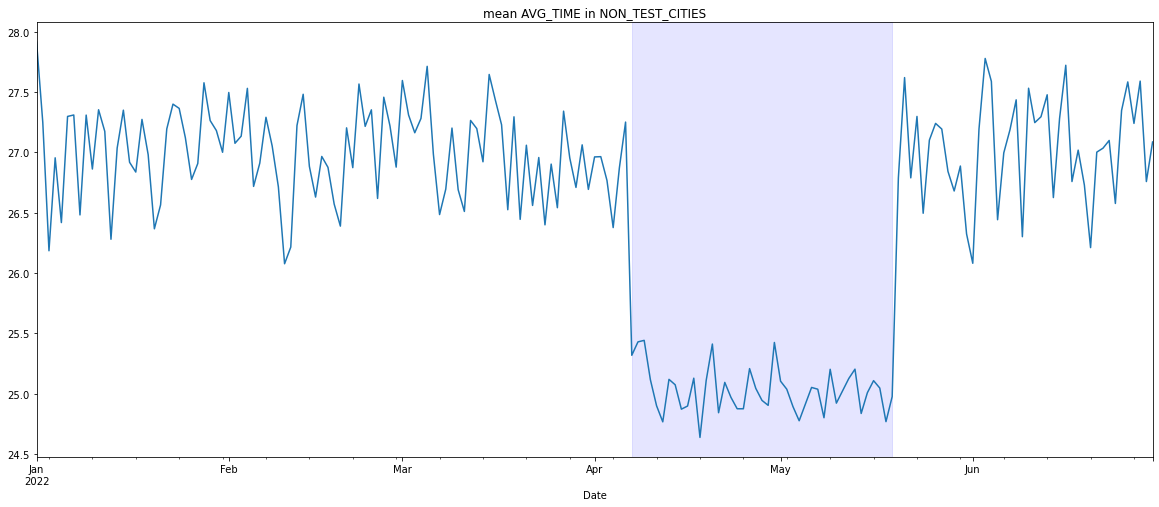

In [37]:
fig = plt.figure(figsize=(20, 8))

ax = df[
    (df['CityName'].isin(test_cities)==False) &
    (df['Category'] == 'пицца') &
    (df['OrderSource'] == 'web')
].groupby(['Date'])['avg_time'].\
mean().plot(x='Date', y= 'avg_time');
ax.axvspan(start_date, end_date, color="blue", alpha=0.1);
ax.set_title('mean AVG_TIME in NON_TEST_CITIES');

Люди быстрее оформляли заказ пиццы на сайте, когда пицца была отсортирована по возрастанию цены.  
Это предположение так же можно было бы проверить, а также посмотреть на конверсию - **чаще** ли они стали оформлять (или только **быстрее**).

##### Дополнительно можно проверить, есть ли разница в среднем чеке:

In [38]:
df.groupby('flag')['avg_price'].mean()

flag
control    610.443580
test       516.007117
Name: avg_price, dtype: float64

Визуально в тестовой группе средний чек **меньше**, необходимо оценить статистическу значимость этой разницы.

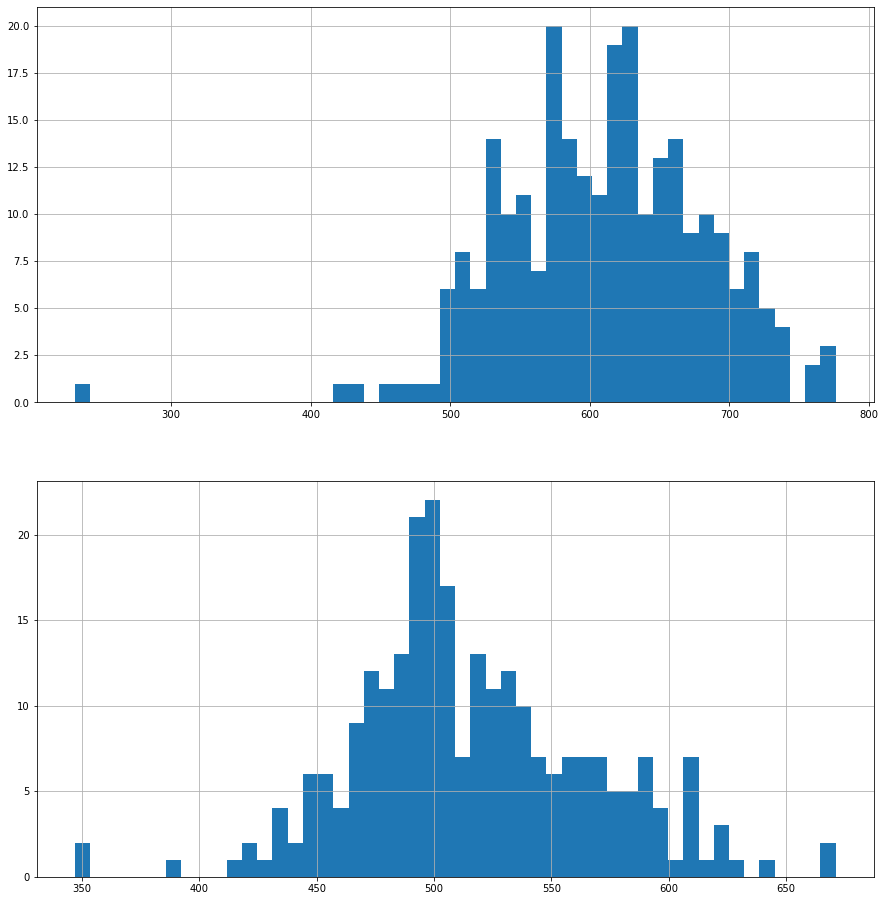

In [39]:
#посмотрим на распределение данных в группах

bins = 50

fig, ax = plt.subplots(2, 1, figsize=(15, 16))
df[df['flag'] == 'control']['avg_price'].hist(bins=bins, ax=ax[0]);
df[df['flag'] == 'test']['avg_price'].hist(bins=bins, ax=ax[1]);

Применим бутстреп, оценим разницу между группами.

In [40]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_sf
import bootstrapped.compare_functions as bs_cf

In [41]:
test = df[df['flag'] == 'test']['avg_price'].values
ctrl = df[df['flag'] == 'control']['avg_price'].values

In [42]:
boot_results = bs.bootstrap_ab(
    test = test,
    ctrl=ctrl,
    stat_func=bs_sf.mean,
    compare_func=bs_cf.difference,
    return_distribution=True
)

borders = np.percentile(boot_results, [2.5, 97.5]) #границы 95%-го доверительного интервала для наших разниц средних
borders

array([-105.02764766,  -83.62741013])

Разница **статистически значима** (т.к. 0 не входит в доверительный интервал).  
График:

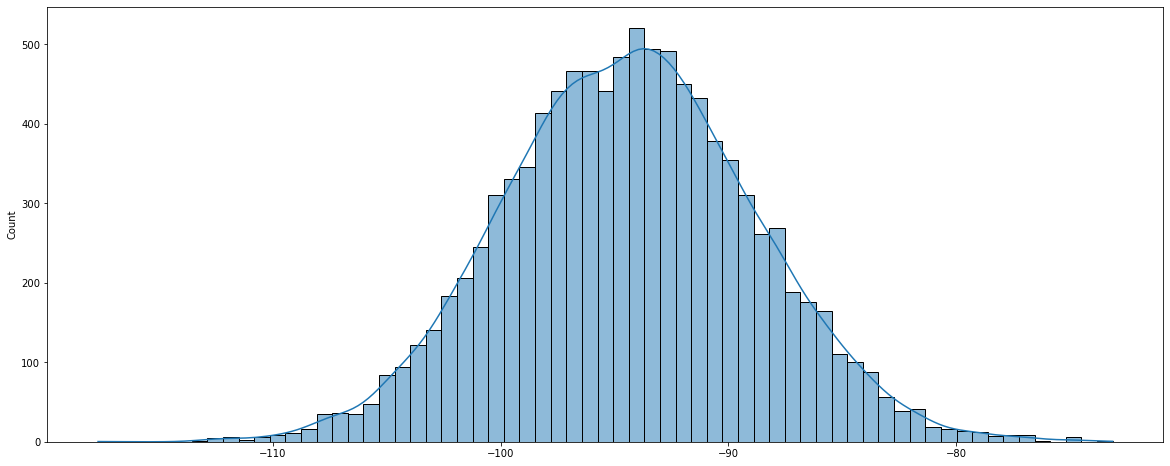

In [43]:
fig = plt.figure(figsize=(20, 8))

sns.histplot(boot_results, kde=True);

#### Выводы:  
(при допущениях, что контрольная группа определена верна, что в контрольной группе параллельно не проводились эксперименты)

* в период эксперимента наблюдалось снижение среднего времени заказа - сильнее всего в группе, для которой сортировка происходила по убыванию цены;  
* эксперимент не оказал существенного влияния на выручку от заказов на пиццу через сайт;
* средний чек по заказам на пиццу через сайт в тестовых городах показал снижение во время эксперимента по сравнению с контрольной группой.